In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage
from torchvision import models
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit

!pip install pycm livelossplot
%pylab inline

from livelossplot import PlotLosses
from pycm import *

import matplotlib.pyplot as plt
import csv

     |████████████████████████████████| 61kB 2.9MB/s 
     |████████████████████████████████| 552kB 11.7MB/s 
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Normalize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
!unzip -q "/content/gdrive/My Drive/acse-miniproject.zip"

In [0]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value 
    and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

set_seed(42)

True

In [0]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


# 1. Load Data

In [0]:
import json
import os
from os.path import join as pjoin
from scipy import misc
from PIL import Image

In [0]:
def load_mapping(fname):
    '''
    Load the classes from the json file.
    ------
    fname:  the path of the json file.  
    ------
    return: get folders
    '''
    with open(fname, mode="r") as f:
        folder_to_class = json.load(f)
    
    return folder_to_class

classes = load_mapping("./mapping.json")

In [0]:
def load_train_data(data_dir):
    '''
    Load the training data and its lables from the file directory.
    Count the number of gray images to see their proportion and 
    change them to 3-channel images.
    ------
    data_dir: the directory of training data.  
    '''

    count = 0
    gray_count = 0
    all_images = []
    labels = []
    tmp_label = 0
    
    for guy in os.listdir(data_dir):
        # something in files but shouldn't be included
        if guy == '.DS_Store':
            continue
        
        # set the corresponding label for different images
        tmp_label = classes[guy]
            
        person_dir_1 = pjoin(data_dir, guy)
        person_dir = pjoin(person_dir_1, "images")
        for i in os.listdir(person_dir):
            image_dir = pjoin(person_dir, i)
            img2 = Image.open(image_dir)
            img2=np.array(img2)
            
            # process the gray-image
            if len(img2.shape) == 2:
                img2 = np.stack((img2, img2, img2), axis=-1)
                gray_count+=1
        
            all_images.append(img2)
            labels.append(tmp_label)
            count = count+1
    print(count)
    
    return count, all_images, gray_count, labels

def load_test_data(data_dir):
    '''
    Load the test data from the file directory.
    Count the number of gray images to see their proportion and 
    change them to 3-channel images.
    ------
    data_dir: the directory of test data.  
    '''

    count = 0
    gray_count = 0
    all_images = []
    file_name = []

    person_dir = pjoin(data_dir, "images")
    for i in os.listdir(person_dir):
        image_dir = pjoin(person_dir, i)  
        
        # something in files but shouldn't be included
        if i == ".ipynb_checkpoints":
            continue
        tmp_file = i
        file_name.append(i.lower())
        
        img2 = Image.open(image_dir)
        img2=np.array(img2)

        if len(img2.shape) == 2:
            img2 = np.stack((img2, img2, img2), axis=-1)
            gray_count+=1

        all_images.append(img2)
        
        count = count+1
    print(count)
    
    return count, all_images, gray_count, file_name

In [0]:
class MiniDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Initialize the arguments of a dataset.
        ------
        data:      a list containing the data e.g. images
        targets:   a list containing all the labels
        transform: optional transform to be applied on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

# taken from: https://discuss.pytorch.org/t/torch-utils-data-dataset-random-split/32209/4 (Thanks ptrblk!)
class Subset2Dataset(Dataset):
    def __init__(self, subset, transform=None):
        """
        Initialize the arguments of a sub dataset.
        ------
        subset (Tensor): a tensor containing the data 
        transform:       optional transform to be applied on a sample.
        """
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

## Calculate the mean and standard deviation of images
```means = [(images[:, i, :, :]/255).mean() for i in range(3)]```

```std = [(images[:, i, :, :]/255).std() for i in range(3)]```



In [0]:
means = [0.48024578664981976, 0.44807218089384243, 0.3975477478649683]
stds = [0.27698640690882403, 0.26906448510256065, 0.28208190621058304]

train_transform = Compose([
    ToPILImage(),
    # transforms.ColorJitter(brightness=0.3),
    transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomRotation(10),
    # transforms.RandomCrop(224, padding=4)
    transforms.Resize(224),
    ToTensor(),
    transforms.Normalize(means, stds)
])

val_transform = Compose([
    ToPILImage(),
    transforms.Resize(224),
    ToTensor(),
    transforms.Normalize(means, stds),
])

## Load training data

In [0]:
all_count, images, gray_count,  labels = load_train_data("./train")

100000


In [0]:
MiniTrain_train = MiniDataset(images, labels)
full_set = MiniDataset(images, labels, transform=train_transform)
print("Non-transform full training set length: ", len(MiniTrain_train))
print("Train-transform full training set length: ", len(full_set))

Non-transform full training set length:  100000
Train-transform full training set length:  100000


### Run the following cell only once for ***EACH RUNTIME***

In [0]:
# Split the whole training data to training, validation and test sets
train_size, val_size, test_size = 80000, 10000, 10000
train_subset, val_subset, test_subset = random_split(MiniTrain_train, [train_size, val_size, test_size])

# Do the corresponding transforms to the three subsets
train_set = Subset2Dataset(train_subset, transform=train_transform)
val_set   = Subset2Dataset(val_subset, transform=val_transform)
test_set  = Subset2Dataset(test_subset, transform=val_transform)

print("Train set length: ", len(train_set))
print("Validation set length: ", len(val_set))
print("Test set length: ", len(test_set))

Train set length:  80000
Validation set length:  10000
Test set length:  10000


In [0]:
# Check seed fixed, remember information below
print("Tensor first channel: \n", train_set.__getitem__(0)[0][0])
print("Tensor shape: ", train_set.__getitem__(0)[0].shape)
print("Label: ", train_set.__getitem__(0)[1])

Tensor first channel: 
 tensor([[-0.9410, -0.9410, -0.9835,  ..., -0.5870, -0.5446, -0.5446],
        [-0.9410, -0.9410, -0.9835,  ..., -0.5870, -0.5446, -0.5446],
        [-0.9551, -0.9551, -0.9976,  ..., -0.6295, -0.5870, -0.5870],
        ...,
        [ 0.8996,  0.8996,  0.9137,  ..., -0.1057, -0.2472, -0.2472],
        [ 0.8996,  0.8996,  0.9137,  ..., -0.0773, -0.1764, -0.1764],
        [ 0.8996,  0.8996,  0.9137,  ..., -0.0773, -0.1764, -0.1764]])
Tensor shape:  torch.Size([3, 224, 224])
Label:  61


## Load unlabelled test data

In [0]:
all_count, test_images, gray_count, file_name = load_test_data("./test")

test_labels = torch.zeros([10000], dtype=torch.int32)
MiniTest = MiniDataset(test_images, test_labels, transform=val_transform)
print("Unlabelled test set length: ", len(MiniTest))

10000
Unlabelled test set length:  10000


# 2. Set up model functions

In [0]:
def train(model, optimizer, criterion, data_loader):
    '''
    Train the model with provided training data.
    ------
    model:       the neutral network
    optimizer:   optimizer used to update the weight parameters
    criterion:   criterion used to calculate the loss
    data_loader: the training dataloader
    '''
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X)
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += f1_score(y.cpu().numpy(), y_pred.detach().cpu().numpy(), average='macro')*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    '''
    Test the model with provided validation data.
    ------
    model:       the neutral network
    criterion:   criterion used to calculate the loss
    data_loader: the validation dataloader
    '''
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X)
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += f1_score(y.cpu().numpy(), y_pred.cpu().numpy(), average='macro')*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

def evaluate(model, data_loader):
    '''
    Evaluate the model with test data(no label) and output a .csv file.
    ------
    model:       the trained model
    data_loader: the test dataloader
    '''
    model.eval()
    f = open('test_result.csv', 'w+')
    with f:
        fnames = ['Filename', 'Label']
        writer = csv.DictWriter(f, fieldnames=fnames)    
        writer.writeheader()
        i=0
        for X, y in data_loader:
            with torch.no_grad():
                X, y = X.to(device), y.to(device)
                a2 = model(X) #What does this have to look like for our conv-net? Make the changes!
                y_pred = F.log_softmax(a2, dim=1).max(1)[1]
                for x in range(1000):
                    writer.writerow({'Filename' : file_name[i], 'Label': y_pred[x].item()}) 
                    i+=1

In [0]:
def train_model(model, 
                momentum=0.5, 
                weight_decay=0, 
                lr=0.02, 
                n_epochs=5, 
                batch_size=64, 
                test_batch_size=1000, 
                best_accuracy=0, 
                save_file=False, 
                model_save_name=None):
    '''
    Train the model with training dataset and validate dataset.
    ------
    model:           the neutral network
    momentum:        the parameter that helps accelerate optimizer
    weight_deacy:    the parameter of L2-Regularization
    lr:              the learning rate of optimizer
    n_epochs:        the number of epochs
    batch_size:      the batch size of training set
    test_batch_size: the batch size of validation and test sets
    best_accuracy:   the best accuracy if previously trained model used
    save_file:       whether to save the model file of this training
    model_save_name: the path of file you want to save
    '''
    # set_seed(42)
    if save_file and not model_save_name:
        print("No file name specified.")
        return
        
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    validation_loader = DataLoader(val_set, batch_size=test_batch_size, shuffle=False, num_workers=0)

    liveloss = PlotLosses()
    for epoch in range(n_epochs):
        print("Epoch %s started..." % (epoch + 1))

        logs = {}
        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()

        if save_file and validation_accuracy.item() > best_accuracy:
            best_accuracy = validation_accuracy.item()
            path = F"/content/gdrive/My Drive/{model_save_name}" 
            torch.save(model.state_dict(), path)
            print("Model %s saved (epoch: %s)" % (model_save_name, epoch + 1))
        
    return model

In [0]:
def train_full_model(model, 
                     momentum=0.5, 
                     weight_decay=0, 
                     lr=0.02, 
                     n_epochs=10, 
                     batch_size=64, 
                     test_batch_size=1000,
                     save_file=False, 
                     model_save_name=None):
    """
    Train the model with entire training set.
    ------
    model:           the neutral network
    momentum:        the parameter that helps accelerate optimizer
    weight_deacy:    the parameter of L2-Regularization
    lr:              the learning rate of optimizer
    n_epochs:        the number of epochs
    batch_size:      the batch size of training set
    test_batch_size: the batch size of validation and test sets
    save_file:       whether to save the model file of this training
    model_save_name: the path of file you want to save
    """
    # set_seed(42)
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(full_set, batch_size=batch_size, shuffle=True, num_workers=0)

    liveloss = PlotLosses()
    for epoch in range(n_epochs):
        logs = {}
        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        logs['val_' + 'log loss'] = 0
        logs['val_' + 'accuracy'] = 0

        liveloss.update(logs)
        liveloss.draw()

        if save_file:
            path = F"/content/gdrive/My Drive/{model_save_name}" 
            torch.save(model.state_dict(), path)
            print("Model %s saved (epoch: %s)" % (model_save_name, epoch + 1))
    
    return model

In [0]:
def get_predictions(model, 
                    test_batch_size=1000):
    '''
    Get predictions for test dataset.
    ------
    model:           the neutral network
    test_batch_size: the batch size of validation and test sets
    '''
    test_loader = DataLoader(MiniTest, batch_size=test_batch_size, shuffle=False, num_workers=0)
    evaluate(model, test_loader)

# 3. ***Train ResNet Wide 101 with:***

* RandomHorizontalFlip(0.5)
* Learning rate = 0.005
* 3 epochs per time

In [0]:
reswide101 = models.wide_resnet101_2(pretrained=True)
fc_in = reswide101.fc.in_features
reswide101.fc = nn.Linear(fc_in, 200)
print(reswide101.fc)

fname = "ResWide101_lr5e-3_full.pth"

reswide101 = train_full_model(reswide101, 
                              lr=0.005, 
                              n_epochs=4, 
                              save_file=True,
                              model_save_name=fname)

Linear(in_features=2048, out_features=200, bias=True)


# 4. Get predictions on unlabelled data

In [0]:
# reswide = reswide.to(device) # use this if model is still on CPU
get_predictions(reswide101)

# Supplementary: Previous plots

## Reswide101

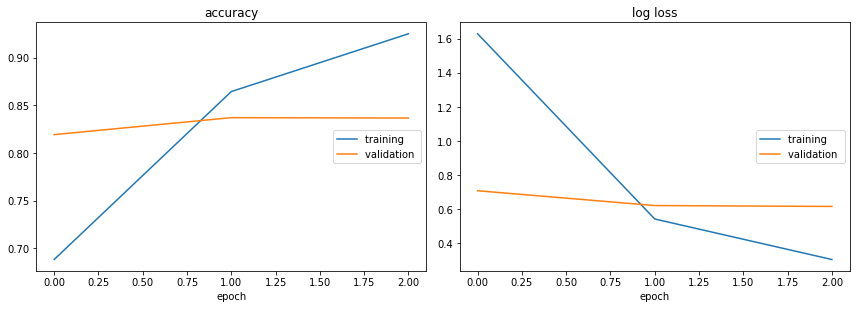

accuracy
	training         	 (min:    0.688, max:    0.925, cur:    0.925)
	validation       	 (min:    0.819, max:    0.837, cur:    0.837)
log loss
	training         	 (min:    0.306, max:    1.629, cur:    0.306)
	validation       	 (min:    0.617, max:    0.709, cur:    0.617)


In [0]:
reswide101 = models.wide_resnet101_2(pretrained=True)
fc_in = reswide101.fc.in_features
reswide101.fc = nn.Linear(fc_in, 200)
print(reswide101.fc)

fname = "ResWide101_lr1e-2.pth"
reswide101 = train_model(reswide101, lr=0.01, n_epochs=3, best_accuracy=0, save_file=True, model_save_name=fname)

## ResNet50

In [0]:
resnet50 = models.resnet50() 
fc_in = resnet50.fc.in_features
resnet50.fc = nn.Linear(fc_in, 200)
print(resnet50.fc)
resnet50.load_state_dict(torch.load("/content/gdrive/My Drive/models/resnet50.pth"))

Linear(in_features=2048, out_features=200, bias=True)


<All keys matched successfully>

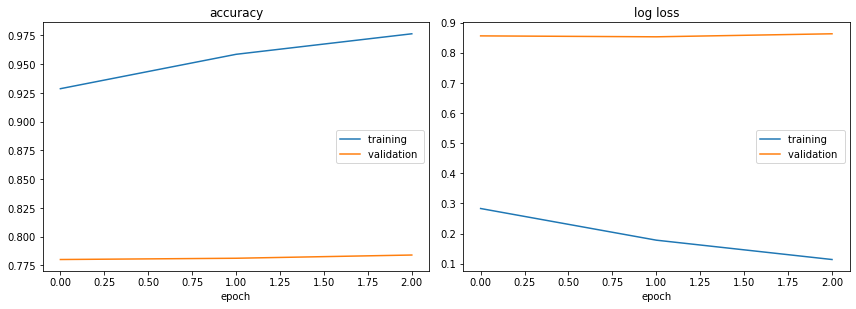

accuracy
	training         	 (min:    0.929, max:    0.976, cur:    0.976)
	validation       	 (min:    0.780, max:    0.784, cur:    0.784)
log loss
	training         	 (min:    0.114, max:    0.283, cur:    0.114)
	validation       	 (min:    0.853, max:    0.863, cur:    0.863)
Model resnet50.pth saved (epoch: 3)


In [0]:
last_best_accuracy = 0.744
resnet50 = train_model(resnet50, lr=0.01, n_epochs=3, best_accuracy=last_best_accuracy, save_file=True, model_save_name="resnet50.pth")

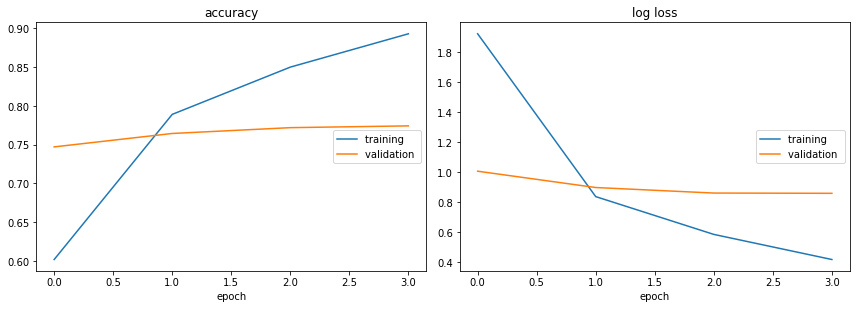

accuracy
	training         	 (min:    0.602, max:    0.893, cur:    0.893)
	validation       	 (min:    0.747, max:    0.774, cur:    0.774)
log loss
	training         	 (min:    0.417, max:    1.923, cur:    0.417)
	validation       	 (min:    0.859, max:    1.006, cur:    0.859)
Model resnet50.pth saved (epoch: 4)
Epoch 4 started...


In [0]:
fname = "ResNet50_lr1e-2_aug.pth"
resnet50 = train_model(resnet50, lr=0.01, n_epochs=6, save_file=True, model_save_name="resnet50.pth")

In [0]:
model_save_name = "try_save.pth"
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(resnet50.state_dict(), path)